Dimension: (20640, 10)

Col info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
None


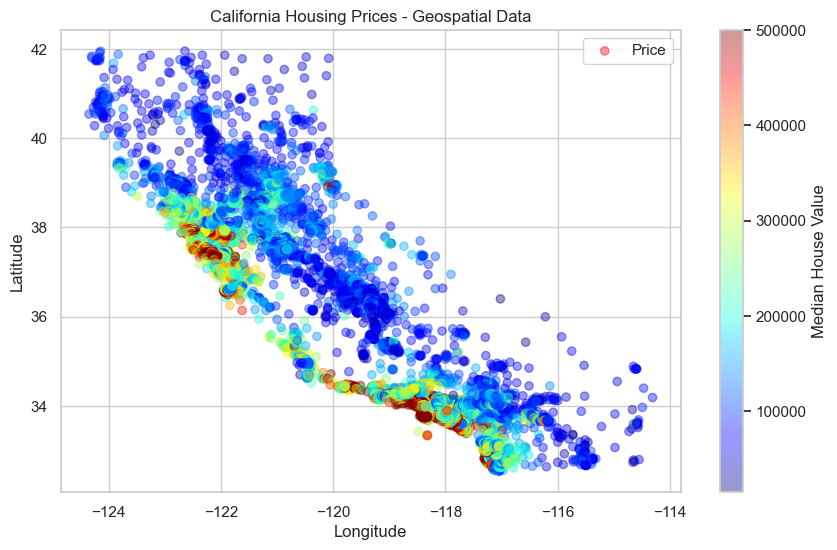

In [36]:
# 1. 匯入套件
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# 設定圖表風格
sns.set(style="whitegrid")

# 2. 載入資料
df = pd.read_csv('data/housing.csv')

# --- 簡單的 EDA (探索式資料分析) ---
print("Dimension:", df.shape)
print("\nCol info:")
print(df.info())

# 地理位置與房價分佈
plt.figure(figsize=(10, 6))
sc = plt.scatter(x=df['longitude'], y=df['latitude'], 
                 alpha=0.4, 
                 c=df['median_house_value'], 
                 cmap=plt.get_cmap("jet"), 
                 label='Price')
plt.colorbar(sc, label='Median House Value')
plt.title("California Housing Prices - Geospatial Data")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()

In [37]:
# --- Data Preprocessing ---

# 處理缺失值：total_bedrooms 有少數缺失(20433 non-null)，我們用中位數填補
median_bedrooms = df['total_bedrooms'].median()
df['total_bedrooms'].fillna(median_bedrooms, inplace=True)

# 處理類別變數：ocean_proximity
df_encoded = pd.get_dummies(df, columns=['ocean_proximity'], drop_first=True)

# 定義特徵 (X) 與 目標 (y)
X = df_encoded.drop('median_house_value', axis=1)
y = df_encoded['median_house_value']

# splitting data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


/var/folders/m2/3y_j_70s38j660c43q1bpl100000gn/T/ipykernel_16855/4025902433.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['total_bedrooms'].fillna(median_bedrooms, inplace=True)


In [38]:
# --- Modeling ---

# 1. 設定Parameter Grid
# 2 x 3 x 3 = 18 種組合
param_grid = {
    'n_estimators': [100, 200],         # 試試看 100 棵或 200 棵樹
    'max_depth': [None, 10, 20],        # 試試看 不限深度、深度10、深度20
    'min_samples_leaf': [1, 2, 4]       # 試試看 葉子最少要有 1, 2, 或 4 筆資料
}

# 2. 初始化模型
rf = RandomForestRegressor(random_state=42)

# 3. 初始化 GridSearchCV
# 折五摺
# n_jobs=-1: 所有的 CPU 核心一起跑
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, scoring='neg_mean_squared_error', 
                           n_jobs=-1, verbose=2)

# 4. 開始訓練
grid_search.fit(X_train, y_train)

# 5. 取得最佳結果
best_rf = grid_search.best_estimator_
print("\n找到的最佳參數組合：")
print(grid_search.best_params_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END max_depth=None, min_samples_leaf=1, n_estimators=100; total time=   9.7s
[CV] END max_depth=None, min_samples_leaf=1, n_estimators=100; total time=   9.8s
[CV] END max_depth=None, min_samples_leaf=1, n_estimators=100; total time=   9.9s
[CV] END max_depth=None, min_samples_leaf=1, n_estimators=100; total time=   9.9s
[CV] END max_depth=None, min_samples_leaf=1, n_estimators=100; total time=  10.0s
[CV] END max_depth=None, min_samples_leaf=2, n_estimators=100; total time=   8.5s
[CV] END max_depth=None, min_samples_leaf=2, n_estimators=100; total time=   8.7s
[CV] END max_depth=None, min_samples_leaf=2, n_estimators=100; total time=   8.9s
[CV] END max_depth=None, min_samples_leaf=1, n_estimators=200; total time=  19.5s
[CV] END max_depth=None, min_samples_leaf=1, n_estimators=200; total time=  19.6s
[CV] END max_depth=None, min_samples_leaf=1, n_estimators=200; total time=  19.7s
[CV] END max_depth=None, min_samples_

In [39]:
# --- Evaluation ---

# 使用最佳模型進行預測
train_predictions = best_rf.predict(X_train)
test_predictions = best_rf.predict(X_test)

# 計算 RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

print(f"最佳模型訓練集 RMSE: ${train_rmse:,.2f}")
print(f"最佳模型測試集 RMSE: ${test_rmse:,.2f}")
print("-" * 30)
print(f"Gap: ${test_rmse - train_rmse:,.2f}")

最佳模型訓練集 RMSE: $23,288.14
最佳模型測試集 RMSE: $48,841.57
------------------------------
Gap: $25,553.43


/var/folders/m2/3y_j_70s38j660c43q1bpl100000gn/T/ipykernel_16855/633693001.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')


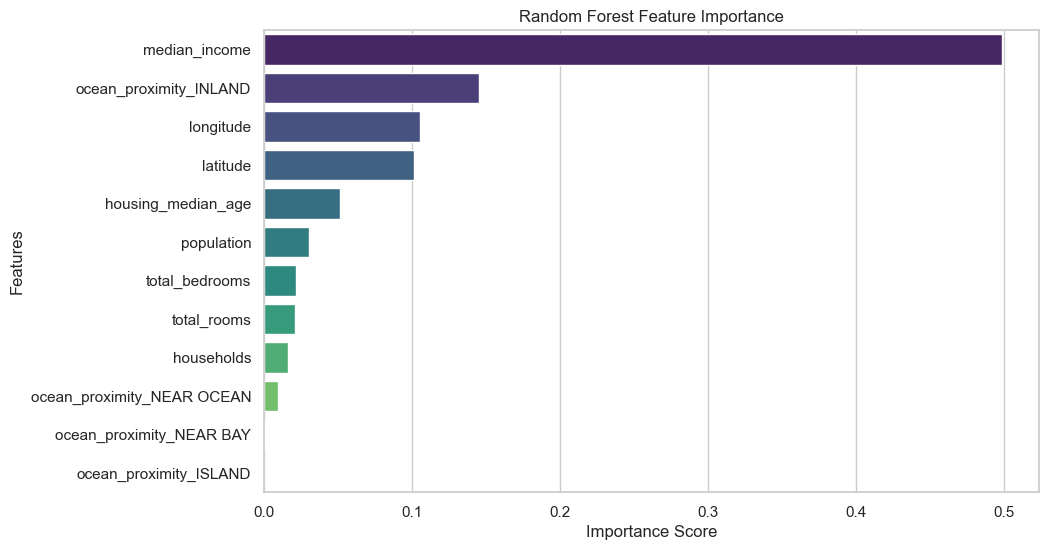

                  Feature  Importance
7           median_income    0.499240
8  ocean_proximity_INLAND    0.145002
0               longitude    0.105516
1                latitude    0.101487
2      housing_median_age    0.050851


In [40]:
# 取得特徵重要性數值
importances = best_rf.feature_importances_

# 取得特徵名稱
feature_names = X_train.columns

# 將兩者結合成 DataFrame 並排序
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False)

# 視覺化
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

# 印出前 5 名重要特徵
print(feature_imp_df.head(5))

/opt/homebrew/Caskroom/miniconda/base/envs/housing_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniconda/base/envs/housing_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23526 (\N{CJK UNIFIED IDEOGRAPH-5BE6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniconda/base/envs/housing_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25151 (\N{CJK UNIFIED IDEOGRAPH-623F}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniconda/base/envs/housing_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20729 (\N{CJK UNIFIED IDEOGRAPH-50F9}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/m

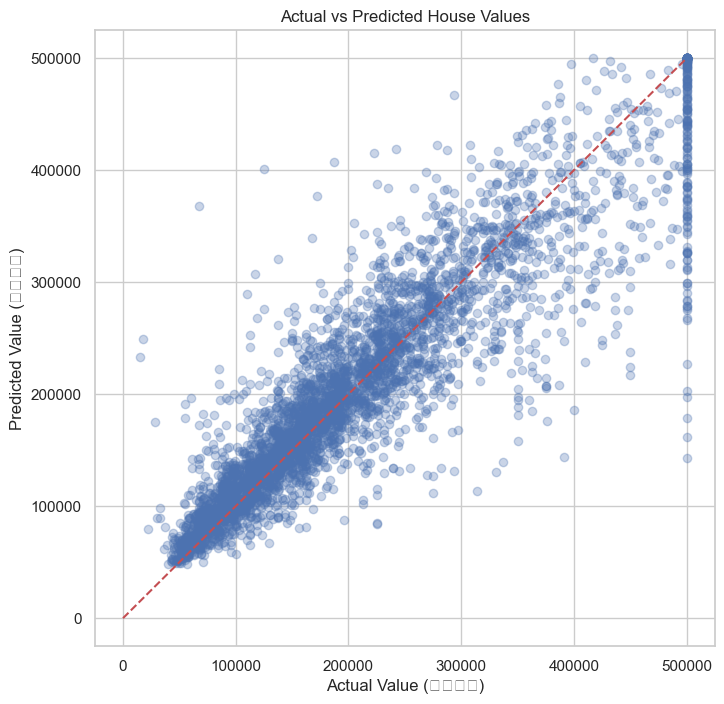

In [41]:
# 繪製「預測值 vs 真實值」散佈圖
plt.figure(figsize=(8, 8))
plt.scatter(y_test, test_predictions, alpha=0.3)
plt.plot([0, 500000], [0, 500000], 'r--') # 畫一條對角線參考
plt.xlabel('Actual Value (真實房價)')
plt.ylabel('Predicted Value (預測房價)')
plt.title('Actual vs Predicted House Values')
plt.show()

In [42]:
import joblib

# 1. 定義檔案名稱
model_filename = 'california_housing_rf_model.pkl'

# 2. 儲存模型 (這會把模型「冷凍」起來存到硬碟)
joblib.dump(best_rf, model_filename)

print(f"模型已成功儲存為: {model_filename}")

模型已成功儲存為: california_housing_rf_model.pkl
